# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


800 Files -> 640 MB in Folder, the first 800 from the folder "train/0"

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


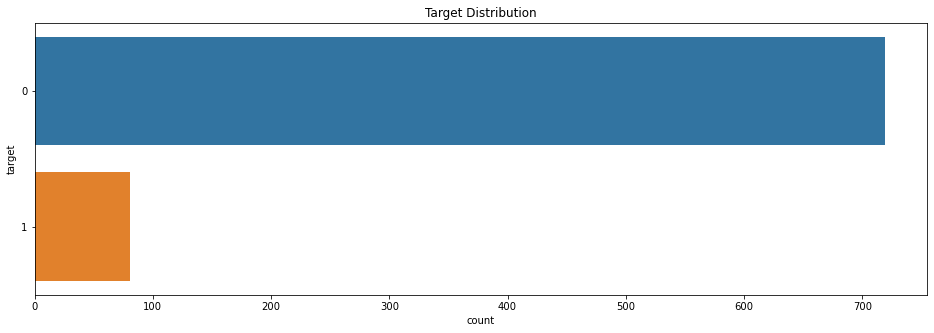

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets): 
        self.image_paths = image_paths
        self.targets = targets

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [28]:
baseline_name = 'efficientnet-b1' # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name: './checkpoint/efficientnet-b1-dbc7070a.pth' # Checkpoint?
}
models = []
device = "cuda"
#epochs = 6
epochs = 1
Batch_Size = 8
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
fold = 0

print(train_test_split(X,Y))

train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y)

model = enetv2(baseline_name, out_dim=1)
model.to(device)

train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    
best_roc_auc = 0.0
last_roc_auc = 0.0
roc_auc = 1.0
epoch = 0
row = 0

#for epoch in range(epochs):
while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    if abs(last_roc_auc - roc_auc) < 0.001:
        row += 1
    else:
        row = 0
    epoch += 1
    last_roc_auc = roc_auc
    train(train_loader, model, optimizer, device=device)
    predictions, valid_targets = evaluate(valid_loader, model, device=device)
    roc_auc = metrics.roc_auc_score(valid_targets, predictions)
    print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")
        
    with codecs.open('log.log', 'a') as up:
        up.write(f"Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
    #    torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
            
        
print('finished')
torch.save(model.state_dict(),baseline_name + '-' + str(fold) + '.pt')
models.append(model)
fold += 1

[array(['./train/selectiontrain/02f983ab6903d65.npy',
       './train/selectiontrain/02fc8d7a939848a.npy',
       './train/selectiontrain/01c925084ca2d91.npy',
       './train/selectiontrain/019967e8abfc520.npy',
       './train/selectiontrain/0191f62e63f4d3e.npy',
       './train/selectiontrain/0360e02cb4ff392.npy',
       './train/selectiontrain/01df3d4f2b5e918.npy',
       './train/selectiontrain/00a9539b1459b8d.npy',
       './train/selectiontrain/022a7ec498c6d2d.npy',
       './train/selectiontrain/01949813672be23.npy',
       './train/selectiontrain/01a1bd190c843f2.npy',
       './train/selectiontrain/02297c71cc9044c.npy',
       './train/selectiontrain/025faec0d6ee4d2.npy',
       './train/selectiontrain/0012dcc6bd1691a.npy',
       './train/selectiontrain/00415f8dc1d7b40.npy',
       './train/selectiontrain/00301235fed8125.npy',
       './train/selectiontrain/00fc0a330ba4b94.npy',
       './train/selectiontrain/0064246c6f69f58.npy',
       './train/selectiontrain/00ab20bd8614be

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.76it/s]


Epoch=1, Valid ROC AUC=0.575652841781874, Distance Actual/Last=0.42434715821812596


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.55it/s]


Epoch=2, Valid ROC AUC=0.5526113671274961, Distance Actual/Last=0.02304147465437789


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.81it/s]


Epoch=3, Valid ROC AUC=0.49039938556067586, Distance Actual/Last=0.062211981566820285


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch=4, Valid ROC AUC=0.5960061443932412, Distance Actual/Last=0.10560675883256532


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=5, Valid ROC AUC=0.4996159754224271, Distance Actual/Last=0.0963901689708141


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=6, Valid ROC AUC=0.6017665130568357, Distance Actual/Last=0.10215053763440862


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.70it/s]


Epoch=7, Valid ROC AUC=0.5180491551459293, Distance Actual/Last=0.0837173579109064


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


Epoch=8, Valid ROC AUC=0.7200460829493087, Distance Actual/Last=0.2019969278033794


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.74it/s]


Epoch=9, Valid ROC AUC=0.5814132104454686, Distance Actual/Last=0.13863287250384015


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.75it/s]


Epoch=10, Valid ROC AUC=0.6682027649769585, Distance Actual/Last=0.08678955453148995


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=11, Valid ROC AUC=0.6981566820276498, Distance Actual/Last=0.02995391705069128


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.85it/s]


Epoch=12, Valid ROC AUC=0.5637480798771122, Distance Actual/Last=0.13440860215053763


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.77it/s]


Epoch=13, Valid ROC AUC=0.6589861751152074, Distance Actual/Last=0.09523809523809523


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


Epoch=14, Valid ROC AUC=0.5176651305683564, Distance Actual/Last=0.14132104454685102


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.55it/s]


Epoch=15, Valid ROC AUC=0.5080645161290323, Distance Actual/Last=0.00960061443932414


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.50it/s]


Epoch=16, Valid ROC AUC=0.48847926267281105, Distance Actual/Last=0.019585253456221197


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


Epoch=17, Valid ROC AUC=0.500768049155146, Distance Actual/Last=0.01228878648233489


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.70it/s]


Epoch=18, Valid ROC AUC=0.5560675883256528, Distance Actual/Last=0.055299539170506895


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.65it/s]


Epoch=19, Valid ROC AUC=0.5967741935483871, Distance Actual/Last=0.04070660522273428


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.79it/s]


Epoch=20, Valid ROC AUC=0.5902457757296466, Distance Actual/Last=0.006528417818740473


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.67it/s]


Epoch=21, Valid ROC AUC=0.49577572964669736, Distance Actual/Last=0.09447004608294929


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.66it/s]


Epoch=22, Valid ROC AUC=0.6774193548387097, Distance Actual/Last=0.18164362519201238


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=23, Valid ROC AUC=0.6244239631336406, Distance Actual/Last=0.05299539170506917


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch=24, Valid ROC AUC=0.49807987711213514, Distance Actual/Last=0.12634408602150543


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.68it/s]


Epoch=25, Valid ROC AUC=0.5729646697388633, Distance Actual/Last=0.07488479262672815


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.75it/s]


Epoch=26, Valid ROC AUC=0.6666666666666667, Distance Actual/Last=0.09370199692780345


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=27, Valid ROC AUC=0.6317204301075269, Distance Actual/Last=0.034946236559139865


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.74it/s]


Epoch=28, Valid ROC AUC=0.6052227342549923, Distance Actual/Last=0.026497695852534586


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.71it/s]


Epoch=29, Valid ROC AUC=0.48463901689708144, Distance Actual/Last=0.12058371735791085


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.70it/s]


Epoch=30, Valid ROC AUC=0.5514592933947772, Distance Actual/Last=0.06682027649769573


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.68it/s]


Epoch=31, Valid ROC AUC=0.5295698924731183, Distance Actual/Last=0.02188940092165892


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=32, Valid ROC AUC=0.607910906298003, Distance Actual/Last=0.07834101382488479


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.68it/s]


Epoch=33, Valid ROC AUC=0.6244239631336406, Distance Actual/Last=0.01651305683563753


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.73it/s]


Epoch=34, Valid ROC AUC=0.6209677419354839, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.35it/s]


Epoch=35, Valid ROC AUC=0.6286482334869431, Distance Actual/Last=0.007680491551459223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=36, Valid ROC AUC=0.6716589861751152, Distance Actual/Last=0.043010752688172116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=37, Valid ROC AUC=0.5591397849462365, Distance Actual/Last=0.1125192012288787


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=38, Valid ROC AUC=0.6662826420890937, Distance Actual/Last=0.1071428571428572


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.61it/s]


Epoch=39, Valid ROC AUC=0.6286482334869432, Distance Actual/Last=0.037634408602150504


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.77it/s]


Epoch=40, Valid ROC AUC=0.5368663594470046, Distance Actual/Last=0.09178187403993865


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=41, Valid ROC AUC=0.49923195084485406, Distance Actual/Last=0.037634408602150504


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=42, Valid ROC AUC=0.6075268817204301, Distance Actual/Last=0.10829493087557607


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.09it/s]


Epoch=43, Valid ROC AUC=0.5841013824884792, Distance Actual/Last=0.02342549923195092


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


Epoch=44, Valid ROC AUC=0.5902457757296466, Distance Actual/Last=0.006144393241167445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.58it/s]


Epoch=45, Valid ROC AUC=0.5568356374807988, Distance Actual/Last=0.033410138248847865


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.72it/s]


Epoch=46, Valid ROC AUC=0.5675883256528418, Distance Actual/Last=0.010752688172043001


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.76it/s]


Epoch=47, Valid ROC AUC=0.575268817204301, Distance Actual/Last=0.007680491551459223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.45it/s]


Epoch=48, Valid ROC AUC=0.5771889400921659, Distance Actual/Last=0.0019201228878649168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.92it/s]


Epoch=49, Valid ROC AUC=0.5856374807987712, Distance Actual/Last=0.008448540706605279


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=50, Valid ROC AUC=0.47926267281105994, Distance Actual/Last=0.10637480798771126


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.67it/s]


Epoch=51, Valid ROC AUC=0.5468509984639017, Distance Actual/Last=0.06758832565284179


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.70it/s]


Epoch=52, Valid ROC AUC=0.6121351766513057, Distance Actual/Last=0.06528417818740395


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.67it/s]


Epoch=53, Valid ROC AUC=0.5783410138248848, Distance Actual/Last=0.03379416282642089


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.64it/s]


Epoch=54, Valid ROC AUC=0.6620583717357911, Distance Actual/Last=0.08371735791090629


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.62it/s]


Epoch=55, Valid ROC AUC=0.6359447004608295, Distance Actual/Last=0.02611367127496156


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.51it/s]


Epoch=56, Valid ROC AUC=0.6720430107526882, Distance Actual/Last=0.036098310291858726


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.68it/s]


Epoch=57, Valid ROC AUC=0.6056067588325653, Distance Actual/Last=0.06643625192012292


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.36it/s]


Epoch=58, Valid ROC AUC=0.618663594470046, Distance Actual/Last=0.013056835637480724


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch=59, Valid ROC AUC=0.630184331797235, Distance Actual/Last=0.011520737327188946


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.60it/s]


Epoch=60, Valid ROC AUC=0.6693548387096774, Distance Actual/Last=0.03917050691244239


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.92it/s]


Epoch=61, Valid ROC AUC=0.6056067588325653, Distance Actual/Last=0.06374807987711206


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.87it/s]


Epoch=62, Valid ROC AUC=0.607910906298003, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.75it/s]


Epoch=63, Valid ROC AUC=0.47235023041474655, Distance Actual/Last=0.1355606758832565


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.42it/s]


Epoch=64, Valid ROC AUC=0.5153609831029186, Distance Actual/Last=0.043010752688172005


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.59it/s]


Epoch=65, Valid ROC AUC=0.47772657450076805, Distance Actual/Last=0.037634408602150504


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.37it/s]


Epoch=66, Valid ROC AUC=0.5599078341013826, Distance Actual/Last=0.08218125960061451


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.48it/s]


Epoch=67, Valid ROC AUC=0.5376344086021505, Distance Actual/Last=0.022273425499232058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.42it/s]


Epoch=68, Valid ROC AUC=0.4381720430107527, Distance Actual/Last=0.09946236559139782


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.59it/s]


Epoch=69, Valid ROC AUC=0.42473118279569894, Distance Actual/Last=0.013440860215053752


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.36it/s]


Epoch=70, Valid ROC AUC=0.4639016897081413, Distance Actual/Last=0.03917050691244234


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=71, Valid ROC AUC=0.4612135176651306, Distance Actual/Last=0.002688172043010695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.24it/s]


Epoch=72, Valid ROC AUC=0.4485407066052227, Distance Actual/Last=0.012672811059907862


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.70it/s]


Epoch=73, Valid ROC AUC=0.44201228878648235, Distance Actual/Last=0.006528417818740362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.48it/s]


Epoch=74, Valid ROC AUC=0.48156682027649766, Distance Actual/Last=0.03955453149001531


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=75, Valid ROC AUC=0.4827188940092165, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.58it/s]


Epoch=76, Valid ROC AUC=0.4708141321044547, Distance Actual/Last=0.011904761904761807


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.19it/s]


Epoch=77, Valid ROC AUC=0.4723502304147465, Distance Actual/Last=0.001536098310291778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.04it/s]


Epoch=78, Valid ROC AUC=0.4688940092165898, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.50it/s]


Epoch=79, Valid ROC AUC=0.4719662058371735, Distance Actual/Last=0.0030721966205837226


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.33it/s]


Epoch=80, Valid ROC AUC=0.467357910906298, Distance Actual/Last=0.004608294930875501


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.66it/s]


Epoch=81, Valid ROC AUC=0.4658218125960061, Distance Actual/Last=0.0015360983102919445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.26it/s]


Epoch=82, Valid ROC AUC=0.4523809523809524, Distance Actual/Last=0.013440860215053696


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch=83, Valid ROC AUC=0.4639016897081414, Distance Actual/Last=0.011520737327189001


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.21it/s]


Epoch=84, Valid ROC AUC=0.4646697388632872, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.82it/s]


Epoch=85, Valid ROC AUC=0.4708141321044547, Distance Actual/Last=0.006144393241167501


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.71it/s]


Epoch=86, Valid ROC AUC=0.47043010752688175, Distance Actual/Last=0.00038402457757297226


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.25it/s]


Epoch=87, Valid ROC AUC=0.467741935483871, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.87it/s]


Epoch=88, Valid ROC AUC=0.4681259600614439, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.60it/s]


Epoch=89, Valid ROC AUC=0.4704301075268817, Distance Actual/Last=0.002304147465437778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.28it/s]


Epoch=90, Valid ROC AUC=0.46735791090629797, Distance Actual/Last=0.0030721966205837226


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.71it/s]


Epoch=91, Valid ROC AUC=0.48156682027649766, Distance Actual/Last=0.014208909370199696


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.09it/s]


Epoch=92, Valid ROC AUC=0.4788786482334869, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.75it/s]


Epoch=93, Valid ROC AUC=0.47619047619047616, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.77it/s]


Epoch=94, Valid ROC AUC=0.47964669738863286, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.28it/s]


Epoch=95, Valid ROC AUC=0.4704301075268817, Distance Actual/Last=0.009216589861751168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.64it/s]


Epoch=96, Valid ROC AUC=0.4197388632872504, Distance Actual/Last=0.05069124423963128


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.41it/s]


Epoch=97, Valid ROC AUC=0.46159754224270355, Distance Actual/Last=0.041858678955453144


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.99it/s]


Epoch=98, Valid ROC AUC=0.5407066052227343, Distance Actual/Last=0.07910906298003073


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.45it/s]


Epoch=99, Valid ROC AUC=0.5714285714285714, Distance Actual/Last=0.030721966205837115


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.34it/s]


Epoch=100, Valid ROC AUC=0.6451612903225807, Distance Actual/Last=0.07373271889400934


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.39it/s]


Epoch=101, Valid ROC AUC=0.6201996927803379, Distance Actual/Last=0.024961597542242808


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.53it/s]


Epoch=102, Valid ROC AUC=0.6328725038402458, Distance Actual/Last=0.012672811059907918


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.28it/s]


Epoch=103, Valid ROC AUC=0.6044546850998463, Distance Actual/Last=0.028417818740399503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=104, Valid ROC AUC=0.5491551459293394, Distance Actual/Last=0.055299539170506895


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.56it/s]


Epoch=105, Valid ROC AUC=0.5192012288786483, Distance Actual/Last=0.02995391705069117


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.47it/s]


Epoch=106, Valid ROC AUC=0.5368663594470046, Distance Actual/Last=0.01766513056835628


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.27it/s]


Epoch=107, Valid ROC AUC=0.5130568356374807, Distance Actual/Last=0.023809523809523836


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.45it/s]


Epoch=108, Valid ROC AUC=0.5625960061443933, Distance Actual/Last=0.04953917050691259


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=109, Valid ROC AUC=0.5675883256528418, Distance Actual/Last=0.004992319508448473


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.37it/s]


Epoch=110, Valid ROC AUC=0.5706605222734256, Distance Actual/Last=0.003072196620583778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.45it/s]


Epoch=111, Valid ROC AUC=0.5625960061443933, Distance Actual/Last=0.008064516129032251


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.51it/s]


Epoch=112, Valid ROC AUC=0.5579877112135176, Distance Actual/Last=0.004608294930875667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


Epoch=113, Valid ROC AUC=0.5587557603686636, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.44it/s]


Epoch=114, Valid ROC AUC=0.5552995391705069, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.47it/s]


Epoch=115, Valid ROC AUC=0.5491551459293396, Distance Actual/Last=0.006144393241167334


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.03it/s]


Epoch=116, Valid ROC AUC=0.5395545314900153, Distance Actual/Last=0.009600614439324251


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.62it/s]


Epoch=117, Valid ROC AUC=0.5456989247311828, Distance Actual/Last=0.006144393241167445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.29it/s]


Epoch=118, Valid ROC AUC=0.5364823348694316, Distance Actual/Last=0.009216589861751112


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.74it/s]


Epoch=119, Valid ROC AUC=0.5337941628264209, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch=120, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.010752688172043001


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.77it/s]


Epoch=121, Valid ROC AUC=0.5449308755760369, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.64it/s]


Epoch=122, Valid ROC AUC=0.5053763440860215, Distance Actual/Last=0.03955453149001542


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


Epoch=123, Valid ROC AUC=0.49385560675883255, Distance Actual/Last=0.011520737327188946


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.84it/s]


Epoch=124, Valid ROC AUC=0.49231950844854067, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.56it/s]


Epoch=125, Valid ROC AUC=0.5602918586789554, Distance Actual/Last=0.0679723502304147


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.27it/s]


Epoch=126, Valid ROC AUC=0.5933179723502304, Distance Actual/Last=0.03302611367127506


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.89it/s]


Epoch=127, Valid ROC AUC=0.6324884792626728, Distance Actual/Last=0.03917050691244239


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.66it/s]


Epoch=128, Valid ROC AUC=0.5691244239631337, Distance Actual/Last=0.06336405529953915


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.21it/s]


Epoch=129, Valid ROC AUC=0.5971582181259601, Distance Actual/Last=0.028033794162826475


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=130, Valid ROC AUC=0.5675883256528418, Distance Actual/Last=0.029569892473118364


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.76it/s]


Epoch=131, Valid ROC AUC=0.5660522273425499, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.56it/s]


Epoch=132, Valid ROC AUC=0.5733486943164363, Distance Actual/Last=0.007296466973886417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.21it/s]


Epoch=133, Valid ROC AUC=0.5718125960061444, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


Epoch=134, Valid ROC AUC=0.5456989247311828, Distance Actual/Last=0.02611367127496167


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.18it/s]


Epoch=135, Valid ROC AUC=0.5748847926267282, Distance Actual/Last=0.029185867895545448


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.47it/s]


Epoch=136, Valid ROC AUC=0.5745007680491552, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.07it/s]


Epoch=137, Valid ROC AUC=0.5867895545314901, Distance Actual/Last=0.01228878648233489


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.35it/s]


Epoch=138, Valid ROC AUC=0.5188172043010753, Distance Actual/Last=0.06797235023041481


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.84it/s]


Epoch=139, Valid ROC AUC=0.5395545314900154, Distance Actual/Last=0.02073732718894017


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.12it/s]


Epoch=140, Valid ROC AUC=0.5023041474654377, Distance Actual/Last=0.0372503840245777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.25it/s]


Epoch=141, Valid ROC AUC=0.5499231950844854, Distance Actual/Last=0.04761904761904767


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.00it/s]


Epoch=142, Valid ROC AUC=0.522273425499232, Distance Actual/Last=0.027649769585253448


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.23it/s]


Epoch=143, Valid ROC AUC=0.543394777265745, Distance Actual/Last=0.021121351766513086


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.15it/s]


Epoch=144, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.004224270353302639


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


Epoch=145, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.19it/s]


Epoch=146, Valid ROC AUC=0.5387864823348694, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.54it/s]


Epoch=147, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.0026881720430108613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.83it/s]


Epoch=148, Valid ROC AUC=0.5165130568356375, Distance Actual/Last=0.024961597542242697


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.80it/s]


Epoch=149, Valid ROC AUC=0.5176651305683564, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.35it/s]


Epoch=150, Valid ROC AUC=0.5825652841781874, Distance Actual/Last=0.06490015360983103


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.21it/s]


Epoch=151, Valid ROC AUC=0.5983102918586789, Distance Actual/Last=0.015745007680491474


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=152, Valid ROC AUC=0.5768049155145929, Distance Actual/Last=0.021505376344086002


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch=153, Valid ROC AUC=0.5261136712749616, Distance Actual/Last=0.05069124423963134


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.10it/s]


Epoch=154, Valid ROC AUC=0.4880952380952381, Distance Actual/Last=0.038018433179723476


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.39it/s]


Epoch=155, Valid ROC AUC=0.5380184331797235, Distance Actual/Last=0.04992319508448545


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.57it/s]


Epoch=156, Valid ROC AUC=0.5472350230414746, Distance Actual/Last=0.009216589861751112


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.07it/s]


Epoch=157, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.008064516129032251


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.34it/s]


Epoch=158, Valid ROC AUC=0.543778801843318, Distance Actual/Last=0.004608294930875556


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.48it/s]


Epoch=159, Valid ROC AUC=0.5526113671274961, Distance Actual/Last=0.008832565284178195


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.48it/s]


Epoch=160, Valid ROC AUC=0.5533794162826422, Distance Actual/Last=0.0007680491551460555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.17it/s]


Epoch=161, Valid ROC AUC=0.5568356374807988, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.44it/s]


Epoch=162, Valid ROC AUC=0.5564516129032258, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.24it/s]


Epoch=163, Valid ROC AUC=0.5587557603686636, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.38it/s]


Epoch=164, Valid ROC AUC=0.5610599078341014, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=165, Valid ROC AUC=0.5591397849462365, Distance Actual/Last=0.0019201228878649168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.11it/s]


Epoch=166, Valid ROC AUC=0.5610599078341014, Distance Actual/Last=0.0019201228878649168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=167, Valid ROC AUC=0.5625960061443933, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=168, Valid ROC AUC=0.5149769585253456, Distance Actual/Last=0.04761904761904767


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=169, Valid ROC AUC=0.5276497695852534, Distance Actual/Last=0.012672811059907807


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=170, Valid ROC AUC=0.5422427035330261, Distance Actual/Last=0.014592933947772613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=171, Valid ROC AUC=0.5368663594470047, Distance Actual/Last=0.00537634408602139


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=172, Valid ROC AUC=0.5407066052227343, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=173, Valid ROC AUC=0.554147465437788, Distance Actual/Last=0.013440860215053752


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.25it/s]


Epoch=174, Valid ROC AUC=0.5867895545314901, Distance Actual/Last=0.03264208909370203


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.42it/s]


Epoch=175, Valid ROC AUC=0.5952380952380952, Distance Actual/Last=0.008448540706605168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.23it/s]


Epoch=176, Valid ROC AUC=0.619815668202765, Distance Actual/Last=0.02457757296466978


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.07it/s]


Epoch=177, Valid ROC AUC=0.5810291858678955, Distance Actual/Last=0.038786482334869476


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.31it/s]


Epoch=178, Valid ROC AUC=0.5453149001536098, Distance Actual/Last=0.0357142857142857


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


Epoch=179, Valid ROC AUC=0.5837173579109064, Distance Actual/Last=0.03840245775729656


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.65it/s]


Epoch=180, Valid ROC AUC=0.511520737327189, Distance Actual/Last=0.07219662058371745


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.65it/s]


Epoch=181, Valid ROC AUC=0.5088325652841782, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=182, Valid ROC AUC=0.4700460829493087, Distance Actual/Last=0.038786482334869476


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=183, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.07450076804915517


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.47it/s]


Epoch=184, Valid ROC AUC=0.5637480798771122, Distance Actual/Last=0.01920122887864828


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.53it/s]


Epoch=185, Valid ROC AUC=0.5714285714285714, Distance Actual/Last=0.007680491551459223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.46it/s]


Epoch=186, Valid ROC AUC=0.5706605222734256, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.27it/s]


Epoch=187, Valid ROC AUC=0.5660522273425499, Distance Actual/Last=0.004608294930875667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.50it/s]


Epoch=188, Valid ROC AUC=0.5683563748079877, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.55it/s]


Epoch=189, Valid ROC AUC=0.5760368663594471, Distance Actual/Last=0.007680491551459334


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.57it/s]


Epoch=190, Valid ROC AUC=0.5729646697388633, Distance Actual/Last=0.003072196620583778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=191, Valid ROC AUC=0.5745007680491552, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.38it/s]


Epoch=192, Valid ROC AUC=0.5721966205837173, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.46it/s]


Epoch=193, Valid ROC AUC=0.5737327188940091, Distance Actual/Last=0.001536098310291778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.62it/s]


Epoch=194, Valid ROC AUC=0.5729646697388633, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.58it/s]


Epoch=195, Valid ROC AUC=0.5718125960061444, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.55it/s]


Epoch=196, Valid ROC AUC=0.5668202764976958, Distance Actual/Last=0.004992319508448584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.44it/s]


Epoch=197, Valid ROC AUC=0.565668202764977, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.58it/s]


Epoch=198, Valid ROC AUC=0.5660522273425499, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.63it/s]


Epoch=199, Valid ROC AUC=0.564516129032258, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.55it/s]


Epoch=200, Valid ROC AUC=0.5499231950844854, Distance Actual/Last=0.014592933947772613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.53it/s]


Epoch=201, Valid ROC AUC=0.5491551459293394, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.49it/s]


Epoch=202, Valid ROC AUC=0.5483870967741935, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.59it/s]


Epoch=203, Valid ROC AUC=0.5460829493087558, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.61it/s]


Epoch=204, Valid ROC AUC=0.5468509984639016, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.43it/s]


Epoch=205, Valid ROC AUC=0.5491551459293396, Distance Actual/Last=0.0023041474654379446


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.48it/s]


Epoch=206, Valid ROC AUC=0.5464669738863287, Distance Actual/Last=0.0026881720430108613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.83it/s]


Epoch=207, Valid ROC AUC=0.5476190476190477, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=208, Valid ROC AUC=0.544162826420891, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=209, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=210, Valid ROC AUC=0.5449308755760369, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=211, Valid ROC AUC=0.5422427035330261, Distance Actual/Last=0.0026881720430108613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=212, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch=213, Valid ROC AUC=0.543778801843318, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=214, Valid ROC AUC=0.5418586789554531, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=215, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=216, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=217, Valid ROC AUC=0.5449308755760368, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=218, Valid ROC AUC=0.5449308755760369, Distance Actual/Last=1.1102230246251565e-16


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.81it/s]


Epoch=219, Valid ROC AUC=0.5468509984639016, Distance Actual/Last=0.0019201228878646948


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=220, Valid ROC AUC=0.5468509984639016, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=221, Valid ROC AUC=0.5453149001536097, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=222, Valid ROC AUC=0.5460829493087558, Distance Actual/Last=0.0007680491551460555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=223, Valid ROC AUC=0.5407066052227343, Distance Actual/Last=0.005376344086021501


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.83it/s]


Epoch=224, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=225, Valid ROC AUC=0.5399385560675884, Distance Actual/Last=0.0007680491551460555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=226, Valid ROC AUC=0.5395545314900154, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=227, Valid ROC AUC=0.5579877112135176, Distance Actual/Last=0.018433179723502224


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=228, Valid ROC AUC=0.5579877112135176, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=229, Valid ROC AUC=0.5568356374807988, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=230, Valid ROC AUC=0.5587557603686636, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=231, Valid ROC AUC=0.5587557603686636, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=232, Valid ROC AUC=0.5595238095238095, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=233, Valid ROC AUC=0.5564516129032258, Distance Actual/Last=0.003072196620583778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=234, Valid ROC AUC=0.5556835637480799, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=235, Valid ROC AUC=0.5556835637480799, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=236, Valid ROC AUC=0.554531490015361, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=237, Valid ROC AUC=0.5506912442396313, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.10it/s]


Epoch=238, Valid ROC AUC=0.5591397849462365, Distance Actual/Last=0.008448540706605168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=239, Valid ROC AUC=0.5595238095238095, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=240, Valid ROC AUC=0.5583717357910907, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=241, Valid ROC AUC=0.5518433179723503, Distance Actual/Last=0.006528417818740362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.81it/s]


Epoch=242, Valid ROC AUC=0.5514592933947773, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=243, Valid ROC AUC=0.5506912442396312, Distance Actual/Last=0.0007680491551460555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.66it/s]


Epoch=244, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.011520737327188835


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=245, Valid ROC AUC=0.5395545314900154, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=246, Valid ROC AUC=0.5391705069124424, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=247, Valid ROC AUC=0.5725806451612903, Distance Actual/Last=0.033410138248847865


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=248, Valid ROC AUC=0.5460829493087558, Distance Actual/Last=0.026497695852534475


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=249, Valid ROC AUC=0.4577572964669739, Distance Actual/Last=0.0883256528417819


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=250, Valid ROC AUC=0.5088325652841782, Distance Actual/Last=0.05107526881720431


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=251, Valid ROC AUC=0.5384024577572964, Distance Actual/Last=0.029569892473118253


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=252, Valid ROC AUC=0.5341781874039938, Distance Actual/Last=0.004224270353302639


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=253, Valid ROC AUC=0.4919354838709678, Distance Actual/Last=0.042242703533026005


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=254, Valid ROC AUC=0.46082949308755755, Distance Actual/Last=0.031105990783410253


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=255, Valid ROC AUC=0.47004608294930866, Distance Actual/Last=0.009216589861751112


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s]


Epoch=256, Valid ROC AUC=0.4834869431643625, Distance Actual/Last=0.013440860215053863


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.11it/s]


Epoch=257, Valid ROC AUC=0.4915514592933948, Distance Actual/Last=0.008064516129032251


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=258, Valid ROC AUC=0.4934715821812596, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=259, Valid ROC AUC=0.5049923195084485, Distance Actual/Last=0.01152073732718889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=260, Valid ROC AUC=0.5272657450076805, Distance Actual/Last=0.022273425499232058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=261, Valid ROC AUC=0.5276497695852534, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=262, Valid ROC AUC=0.5303379416282642, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=263, Valid ROC AUC=0.5318740399385561, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=264, Valid ROC AUC=0.521505376344086, Distance Actual/Last=0.010368663594470084


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=265, Valid ROC AUC=0.5253456221198156, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=266, Valid ROC AUC=0.532642089093702, Distance Actual/Last=0.007296466973886417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=267, Valid ROC AUC=0.5349462365591398, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=268, Valid ROC AUC=0.5384024577572966, Distance Actual/Last=0.003456221198156806


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=269, Valid ROC AUC=0.5418586789554531, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=270, Valid ROC AUC=0.5418586789554531, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.10it/s]


Epoch=271, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=272, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.81it/s]


Epoch=273, Valid ROC AUC=0.5518433179723503, Distance Actual/Last=0.007296466973886417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=274, Valid ROC AUC=0.5506912442396313, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=275, Valid ROC AUC=0.5480030721966206, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=276, Valid ROC AUC=0.5480030721966206, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=277, Valid ROC AUC=0.5456989247311828, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=278, Valid ROC AUC=0.5526113671274961, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=279, Valid ROC AUC=0.5568356374807988, Distance Actual/Last=0.004224270353302639


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=280, Valid ROC AUC=0.5583717357910907, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=281, Valid ROC AUC=0.565668202764977, Distance Actual/Last=0.007296466973886306


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=282, Valid ROC AUC=0.5691244239631337, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=283, Valid ROC AUC=0.5272657450076804, Distance Actual/Last=0.041858678955453255


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=284, Valid ROC AUC=0.5122887864823349, Distance Actual/Last=0.01497695852534553


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=285, Valid ROC AUC=0.499231950844854, Distance Actual/Last=0.01305683563748089


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=286, Valid ROC AUC=0.49577572964669736, Distance Actual/Last=0.0034562211981566393


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=287, Valid ROC AUC=0.49385560675883255, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=288, Valid ROC AUC=0.49308755760368667, Distance Actual/Last=0.000768049155145889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=289, Valid ROC AUC=0.489247311827957, Distance Actual/Last=0.003840245775729667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=290, Valid ROC AUC=0.5007680491551458, Distance Actual/Last=0.011520737327188835


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=291, Valid ROC AUC=0.49500768049155147, Distance Actual/Last=0.005760368663594362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=292, Valid ROC AUC=0.4946236559139785, Distance Actual/Last=0.00038402457757297226


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.85it/s]


Epoch=293, Valid ROC AUC=0.5192012288786483, Distance Actual/Last=0.02457757296466978


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=294, Valid ROC AUC=0.5218894009216589, Distance Actual/Last=0.0026881720430106393


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=295, Valid ROC AUC=0.5153609831029186, Distance Actual/Last=0.006528417818740362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=296, Valid ROC AUC=0.5153609831029187, Distance Actual/Last=1.1102230246251565e-16


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=297, Valid ROC AUC=0.5122887864823349, Distance Actual/Last=0.003072196620583778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=298, Valid ROC AUC=0.5084485407066052, Distance Actual/Last=0.0038402457757297226


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.12it/s]


Epoch=299, Valid ROC AUC=0.5276497695852534, Distance Actual/Last=0.01920122887864828


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=300, Valid ROC AUC=0.5264976958525345, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=301, Valid ROC AUC=0.5764208909370199, Distance Actual/Last=0.049923195084485394


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.16it/s]


Epoch=302, Valid ROC AUC=0.5030721966205837, Distance Actual/Last=0.0733486943164362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=303, Valid ROC AUC=0.5468509984639016, Distance Actual/Last=0.04377880184331795


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=304, Valid ROC AUC=0.532258064516129, Distance Actual/Last=0.014592933947772613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=305, Valid ROC AUC=0.5314900153609831, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=306, Valid ROC AUC=0.564900153609831, Distance Actual/Last=0.033410138248847976


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=307, Valid ROC AUC=0.5775729646697388, Distance Actual/Last=0.012672811059907807


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=308, Valid ROC AUC=0.6063748079877112, Distance Actual/Last=0.02880184331797231


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=309, Valid ROC AUC=0.5249615975422428, Distance Actual/Last=0.08141321044546834


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=310, Valid ROC AUC=0.5844854070660522, Distance Actual/Last=0.05952380952380942


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s]


Epoch=311, Valid ROC AUC=0.5779569892473119, Distance Actual/Last=0.006528417818740362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=312, Valid ROC AUC=0.6063748079877112, Distance Actual/Last=0.02841781874039928


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=313, Valid ROC AUC=0.6117511520737327, Distance Actual/Last=0.005376344086021501


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=314, Valid ROC AUC=0.5906298003072197, Distance Actual/Last=0.021121351766512975


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.16it/s]


Epoch=315, Valid ROC AUC=0.5387864823348694, Distance Actual/Last=0.05184331797235031


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=316, Valid ROC AUC=0.5353302611367128, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=317, Valid ROC AUC=0.5399385560675883, Distance Actual/Last=0.004608294930875556


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=318, Valid ROC AUC=0.5453149001536097, Distance Actual/Last=0.00537634408602139


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=319, Valid ROC AUC=0.5418586789554531, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=320, Valid ROC AUC=0.5403225806451613, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=321, Valid ROC AUC=0.44470046082949305, Distance Actual/Last=0.0956221198156682


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=322, Valid ROC AUC=0.5487711213517665, Distance Actual/Last=0.10407066052227348


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=323, Valid ROC AUC=0.5011520737327189, Distance Actual/Last=0.04761904761904767


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=324, Valid ROC AUC=0.5122887864823349, Distance Actual/Last=0.011136712749616029


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=325, Valid ROC AUC=0.4854070660522274, Distance Actual/Last=0.026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=326, Valid ROC AUC=0.6420890937019968, Distance Actual/Last=0.15668202764976946


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=327, Valid ROC AUC=0.618663594470046, Distance Actual/Last=0.023425499231950808


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=328, Valid ROC AUC=0.6298003072196621, Distance Actual/Last=0.011136712749616029


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=329, Valid ROC AUC=0.6877880184331797, Distance Actual/Last=0.057987711213517645


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=330, Valid ROC AUC=0.6866359447004609, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=331, Valid ROC AUC=0.685099846390169, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=332, Valid ROC AUC=0.6286482334869432, Distance Actual/Last=0.056451612903225756


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=333, Valid ROC AUC=0.6298003072196621, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=334, Valid ROC AUC=0.6259600614439325, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=335, Valid ROC AUC=0.598310291858679, Distance Actual/Last=0.027649769585253448


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=336, Valid ROC AUC=0.6175115207373272, Distance Actual/Last=0.01920122887864817


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=337, Valid ROC AUC=0.6048387096774194, Distance Actual/Last=0.012672811059907807


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=338, Valid ROC AUC=0.6021505376344086, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=339, Valid ROC AUC=0.5725806451612903, Distance Actual/Last=0.029569892473118364


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=340, Valid ROC AUC=0.5606758832565284, Distance Actual/Last=0.011904761904761862


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=341, Valid ROC AUC=0.5157450076804916, Distance Actual/Last=0.04493087557603681


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=342, Valid ROC AUC=0.5426267281105991, Distance Actual/Last=0.026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=343, Valid ROC AUC=0.5748847926267281, Distance Actual/Last=0.032258064516129004


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=344, Valid ROC AUC=0.5760368663594471, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=345, Valid ROC AUC=0.5779569892473118, Distance Actual/Last=0.0019201228878646948


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=346, Valid ROC AUC=0.5829493087557603, Distance Actual/Last=0.004992319508448584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=347, Valid ROC AUC=0.5791090629800307, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=348, Valid ROC AUC=0.5718125960061444, Distance Actual/Last=0.007296466973886306


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=349, Valid ROC AUC=0.564900153609831, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=350, Valid ROC AUC=0.5714285714285715, Distance Actual/Last=0.006528417818740473


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=351, Valid ROC AUC=0.5668202764976957, Distance Actual/Last=0.004608294930875778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=352, Valid ROC AUC=0.5660522273425499, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=353, Valid ROC AUC=0.5745007680491552, Distance Actual/Last=0.008448540706605279


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=354, Valid ROC AUC=0.5779569892473118, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=355, Valid ROC AUC=0.5602918586789555, Distance Actual/Last=0.01766513056835628


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=356, Valid ROC AUC=0.5606758832565284, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=357, Valid ROC AUC=0.5695084485407066, Distance Actual/Last=0.008832565284178195


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=358, Valid ROC AUC=0.5595238095238095, Distance Actual/Last=0.009984639016897057


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=359, Valid ROC AUC=0.5552995391705069, Distance Actual/Last=0.004224270353302639


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=360, Valid ROC AUC=0.5622119815668203, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=361, Valid ROC AUC=0.564900153609831, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=362, Valid ROC AUC=0.5625960061443933, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=363, Valid ROC AUC=0.5629800307219661, Distance Actual/Last=0.0003840245775728057


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=364, Valid ROC AUC=0.5664362519201229, Distance Actual/Last=0.003456221198156806


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=365, Valid ROC AUC=0.5061443932411674, Distance Actual/Last=0.06029185867895548


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=366, Valid ROC AUC=0.5199692780337941, Distance Actual/Last=0.013824884792626668


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.83it/s]


Epoch=367, Valid ROC AUC=0.5161290322580645, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=368, Valid ROC AUC=0.5207373271889401, Distance Actual/Last=0.004608294930875556


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=369, Valid ROC AUC=0.522273425499232, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=370, Valid ROC AUC=0.5241935483870968, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=371, Valid ROC AUC=0.5272657450076805, Distance Actual/Last=0.003072196620583778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.82it/s]


Epoch=372, Valid ROC AUC=0.5307219662058371, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=373, Valid ROC AUC=0.5326420890937019, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=374, Valid ROC AUC=0.5314900153609832, Distance Actual/Last=0.0011520737327187502


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=375, Valid ROC AUC=0.5288018433179724, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=376, Valid ROC AUC=0.5299539170506913, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.10it/s]


Epoch=377, Valid ROC AUC=0.5314900153609831, Distance Actual/Last=0.001536098310291778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.12it/s]


Epoch=378, Valid ROC AUC=0.5330261136712748, Distance Actual/Last=0.001536098310291778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=379, Valid ROC AUC=0.5341781874039938, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=380, Valid ROC AUC=0.5357142857142857, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=381, Valid ROC AUC=0.5376344086021505, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=382, Valid ROC AUC=0.5268817204301075, Distance Actual/Last=0.010752688172043001


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=383, Valid ROC AUC=0.5249615975422427, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=384, Valid ROC AUC=0.5280337941628264, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=385, Valid ROC AUC=0.5257296466973886, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=386, Valid ROC AUC=0.5268817204301075, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=387, Valid ROC AUC=0.5268817204301075, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=388, Valid ROC AUC=0.5303379416282642, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=389, Valid ROC AUC=0.5245775729646698, Distance Actual/Last=0.005760368663594417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=390, Valid ROC AUC=0.5253456221198157, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=391, Valid ROC AUC=0.5288018433179724, Distance Actual/Last=0.003456221198156695


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=392, Valid ROC AUC=0.5264976958525346, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=393, Valid ROC AUC=0.5280337941628265, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=394, Valid ROC AUC=0.5272657450076805, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=395, Valid ROC AUC=0.4086021505376344, Distance Actual/Last=0.11866359447004615


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=396, Valid ROC AUC=0.5737327188940093, Distance Actual/Last=0.16513056835637496


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=397, Valid ROC AUC=0.5875576036866359, Distance Actual/Last=0.013824884792626557


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.74it/s]


Epoch=398, Valid ROC AUC=0.5944700460829493, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=399, Valid ROC AUC=0.5403225806451613, Distance Actual/Last=0.054147465437788034


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.10it/s]


Epoch=400, Valid ROC AUC=0.5387864823348694, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.04it/s]


Epoch=401, Valid ROC AUC=0.5422427035330262, Distance Actual/Last=0.003456221198156806


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.17it/s]


Epoch=402, Valid ROC AUC=0.543010752688172, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=403, Valid ROC AUC=0.5560675883256528, Distance Actual/Last=0.013056835637480835


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=404, Valid ROC AUC=0.5583717357910906, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=405, Valid ROC AUC=0.5510752688172043, Distance Actual/Last=0.007296466973886306


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=406, Valid ROC AUC=0.5503072196620583, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=407, Valid ROC AUC=0.5445468509984639, Distance Actual/Last=0.005760368663594417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=408, Valid ROC AUC=0.543010752688172, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.12it/s]


Epoch=409, Valid ROC AUC=0.543010752688172, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=410, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.001536098310291778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s]


Epoch=411, Valid ROC AUC=0.5426267281105991, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=412, Valid ROC AUC=0.543010752688172, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=413, Valid ROC AUC=0.5399385560675883, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=414, Valid ROC AUC=0.5595238095238095, Distance Actual/Last=0.019585253456221197


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=415, Valid ROC AUC=0.554147465437788, Distance Actual/Last=0.005376344086021501


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=416, Valid ROC AUC=0.5529953917050692, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=417, Valid ROC AUC=0.5464669738863287, Distance Actual/Last=0.006528417818740473


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=418, Valid ROC AUC=0.5483870967741935, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=419, Valid ROC AUC=0.5464669738863287, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=420, Valid ROC AUC=0.5910138248847926, Distance Actual/Last=0.044546850998463894


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.65it/s]


Epoch=421, Valid ROC AUC=0.5184331797235022, Distance Actual/Last=0.07258064516129037


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=422, Valid ROC AUC=0.4466205837173579, Distance Actual/Last=0.07181259600614431


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=423, Valid ROC AUC=0.48118279569892475, Distance Actual/Last=0.03456221198156684


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=424, Valid ROC AUC=0.48079877112135183, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=425, Valid ROC AUC=0.5303379416282641, Distance Actual/Last=0.049539170506912256


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.11it/s]


Epoch=426, Valid ROC AUC=0.5783410138248848, Distance Actual/Last=0.0480030721966207


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=427, Valid ROC AUC=0.5898617511520736, Distance Actual/Last=0.011520737327188835


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s]


Epoch=428, Valid ROC AUC=0.5710445468509985, Distance Actual/Last=0.01881720430107514


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=429, Valid ROC AUC=0.5837173579109063, Distance Actual/Last=0.012672811059907807


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=430, Valid ROC AUC=0.5906298003072197, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=431, Valid ROC AUC=0.5975422427035331, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=432, Valid ROC AUC=0.6470814132104454, Distance Actual/Last=0.04953917050691237


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=433, Valid ROC AUC=0.6655145929339478, Distance Actual/Last=0.018433179723502335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=434, Valid ROC AUC=0.5069124423963134, Distance Actual/Last=0.15860215053763438


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=435, Valid ROC AUC=0.5395545314900154, Distance Actual/Last=0.03264208909370203


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=436, Valid ROC AUC=0.5668202764976958, Distance Actual/Last=0.02726574500768042


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=437, Valid ROC AUC=0.5867895545314901, Distance Actual/Last=0.019969278033794224


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=438, Valid ROC AUC=0.5933179723502304, Distance Actual/Last=0.006528417818740362


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=439, Valid ROC AUC=0.5963901689708141, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=440, Valid ROC AUC=0.608678955453149, Distance Actual/Last=0.01228878648233489


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=441, Valid ROC AUC=0.6217357910906298, Distance Actual/Last=0.013056835637480835


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.10it/s]


Epoch=442, Valid ROC AUC=0.6102150537634409, Distance Actual/Last=0.011520737327188946


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=443, Valid ROC AUC=0.6144393241167434, Distance Actual/Last=0.004224270353302528


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=444, Valid ROC AUC=0.5906298003072196, Distance Actual/Last=0.023809523809523836


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=445, Valid ROC AUC=0.5898617511520737, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=446, Valid ROC AUC=0.5583717357910907, Distance Actual/Last=0.03149001536098306


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=447, Valid ROC AUC=0.5564516129032258, Distance Actual/Last=0.0019201228878649168


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=448, Valid ROC AUC=0.5572196620583718, Distance Actual/Last=0.0007680491551460555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=449, Valid ROC AUC=0.39285714285714285, Distance Actual/Last=0.16436251920122896


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=450, Valid ROC AUC=0.5867895545314901, Distance Actual/Last=0.19393241167434722


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=451, Valid ROC AUC=0.5280337941628264, Distance Actual/Last=0.0587557603686637


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.17it/s]


Epoch=452, Valid ROC AUC=0.4911674347158218, Distance Actual/Last=0.03686635944700456


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=453, Valid ROC AUC=0.48079877112135183, Distance Actual/Last=0.010368663594469973


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=454, Valid ROC AUC=0.5111367127496159, Distance Actual/Last=0.030337941628264087


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=455, Valid ROC AUC=0.5545314900153611, Distance Actual/Last=0.043394777265745144


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.11it/s]


Epoch=456, Valid ROC AUC=0.59715821812596, Distance Actual/Last=0.04262672811059898


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=457, Valid ROC AUC=0.5825652841781874, Distance Actual/Last=0.014592933947772613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=458, Valid ROC AUC=0.586021505376344, Distance Actual/Last=0.003456221198156584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=459, Valid ROC AUC=0.5852534562211982, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=460, Valid ROC AUC=0.577572964669739, Distance Actual/Last=0.007680491551459223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch=461, Valid ROC AUC=0.5802611367127497, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=462, Valid ROC AUC=0.5637480798771122, Distance Actual/Last=0.01651305683563753


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=463, Valid ROC AUC=0.5656682027649769, Distance Actual/Last=0.0019201228878646948


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=464, Valid ROC AUC=0.5668202764976958, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.99it/s]


Epoch=465, Valid ROC AUC=0.5518433179723502, Distance Actual/Last=0.01497695852534564


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=466, Valid ROC AUC=0.5468509984639017, Distance Actual/Last=0.004992319508448473


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=467, Valid ROC AUC=0.532642089093702, Distance Actual/Last=0.014208909370199696


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=468, Valid ROC AUC=0.5403225806451613, Distance Actual/Last=0.007680491551459223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.05it/s]


Epoch=469, Valid ROC AUC=0.5414746543778802, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=470, Valid ROC AUC=0.47964669738863286, Distance Actual/Last=0.06182795698924737


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=471, Valid ROC AUC=0.6478494623655915, Distance Actual/Last=0.16820276497695863


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.07it/s]


Epoch=472, Valid ROC AUC=0.5207373271889401, Distance Actual/Last=0.12711213517665143


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=473, Valid ROC AUC=0.533026113671275, Distance Actual/Last=0.01228878648233489


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=474, Valid ROC AUC=0.5103686635944701, Distance Actual/Last=0.022657450076804864


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=475, Valid ROC AUC=0.4746543778801843, Distance Actual/Last=0.03571428571428581


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Epoch=476, Valid ROC AUC=0.4473886328725038, Distance Actual/Last=0.027265745007680475


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.85it/s]


Epoch=477, Valid ROC AUC=0.44930875576036866, Distance Actual/Last=0.0019201228878648613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=478, Valid ROC AUC=0.45890937019969275, Distance Actual/Last=0.009600614439324084


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=479, Valid ROC AUC=0.46543778801843316, Distance Actual/Last=0.006528417818740417


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]


Epoch=480, Valid ROC AUC=0.5395545314900153, Distance Actual/Last=0.07411674347158215


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=481, Valid ROC AUC=0.5487711213517665, Distance Actual/Last=0.009216589861751223


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s]


Epoch=482, Valid ROC AUC=0.6217357910906298, Distance Actual/Last=0.07296466973886329


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=483, Valid ROC AUC=0.6728110599078341, Distance Actual/Last=0.051075268817204256


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=484, Valid ROC AUC=0.6144393241167434, Distance Actual/Last=0.05837173579109067


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=485, Valid ROC AUC=0.6282642089093702, Distance Actual/Last=0.01382488479262678


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=486, Valid ROC AUC=0.6524577572964669, Distance Actual/Last=0.024193548387096753


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch=487, Valid ROC AUC=0.6570660522273426, Distance Actual/Last=0.004608294930875667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=488, Valid ROC AUC=0.6559139784946236, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=489, Valid ROC AUC=0.6570660522273426, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=490, Valid ROC AUC=0.6559139784946236, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=491, Valid ROC AUC=0.6574500768049155, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=492, Valid ROC AUC=0.6586021505376345, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=493, Valid ROC AUC=0.6612903225806451, Distance Actual/Last=0.0026881720430106393


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=494, Valid ROC AUC=0.6616743471582182, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=495, Valid ROC AUC=0.6601382488479263, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=496, Valid ROC AUC=0.6620583717357911, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=497, Valid ROC AUC=0.6647465437788018, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.15it/s]


Epoch=498, Valid ROC AUC=0.663594470046083, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=499, Valid ROC AUC=0.6666666666666666, Distance Actual/Last=0.003072196620583667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.09it/s]


Epoch=500, Valid ROC AUC=0.6705069124423962, Distance Actual/Last=0.0038402457757296116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.95it/s]


Epoch=501, Valid ROC AUC=0.6566820276497696, Distance Actual/Last=0.013824884792626668


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.92it/s]


Epoch=502, Valid ROC AUC=0.6566820276497696, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.87it/s]


Epoch=503, Valid ROC AUC=0.6559139784946236, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Epoch=504, Valid ROC AUC=0.6547619047619048, Distance Actual/Last=0.0011520737327188613


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.86it/s]


Epoch=505, Valid ROC AUC=0.6551459293394777, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s]


Epoch=506, Valid ROC AUC=0.6555299539170507, Distance Actual/Last=0.00038402457757302777


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=507, Valid ROC AUC=0.6574500768049155, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=508, Valid ROC AUC=0.6582181259600615, Distance Actual/Last=0.0007680491551459445


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


Epoch=509, Valid ROC AUC=0.6562980030721967, Distance Actual/Last=0.0019201228878648058


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.98it/s]


Epoch=510, Valid ROC AUC=0.6539938556067588, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=511, Valid ROC AUC=0.6562980030721967, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=512, Valid ROC AUC=0.6493855606758833, Distance Actual/Last=0.00691244239631339


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.06it/s]


Epoch=513, Valid ROC AUC=0.6478494623655914, Distance Actual/Last=0.001536098310291889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=514, Valid ROC AUC=0.6505376344086021, Distance Actual/Last=0.0026881720430107503


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.85it/s]


Epoch=515, Valid ROC AUC=0.6501536098310292, Distance Actual/Last=0.00038402457757291675


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.91it/s]


Epoch=516, Valid ROC AUC=0.6478494623655914, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=517, Valid ROC AUC=0.652073732718894, Distance Actual/Last=0.004224270353302639


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.03it/s]


Epoch=518, Valid ROC AUC=0.6497695852534563, Distance Actual/Last=0.0023041474654377225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.94it/s]


Epoch=519, Valid ROC AUC=0.6486175115207373, Distance Actual/Last=0.0011520737327189723


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]


Epoch=520, Valid ROC AUC=0.6509216589861752, Distance Actual/Last=0.0023041474654378336


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s]


Epoch=521, Valid ROC AUC=0.651689708141321, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s]


Epoch=522, Valid ROC AUC=0.6509216589861752, Distance Actual/Last=0.0007680491551458335


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.96it/s]


Epoch=523, Valid ROC AUC=0.6509216589861752, Distance Actual/Last=0.0
finished
